In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
import operator
from functools import reduce

import holoviews as hv
import hvplot.polars  # noqa
import numpy as np
import polars as pl
from icecream import ic
from polars import col

from src.data.database_manager import DatabaseManager
from src.data.quality_checks import check_sample_rate
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.labels import process_labels
from src.features.resampling import add_time_column, downsample
from src.features.scaling import scale_min_max
from src.features.transforming import map_trials, merge_dfs
from src.log_config import configure_logging
from src.plots.plot_stimulus import plot_stimulus_with_shapes

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    stimulus = db.get_table("Feature_Stimulus")
    trials = db.get_table("Trials")

df = merge_dfs([stimulus, trials], on=["trial_id", "participant_id", "trial_number"])


In [5]:
stim = StimulusGenerator(seed=396)
plot_stimulus_with_shapes(stim)

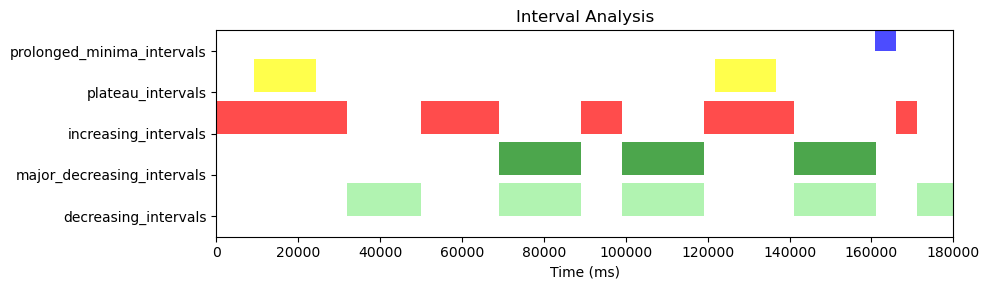

In [6]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors for each type of interval
colors = dict(zip(stim.labels.keys(), ["lightgreen", "green", "red", "yellow", "blue"]))

# Plot patches for each interval type
num_types = len(stim.labels)
for i, (interval_type, intervals) in enumerate(stim.labels.items()):
    for start, end in intervals:
        ax.add_patch(
            patches.Rectangle(
                (start, i),
                end - start,
                0.8,
                facecolor=colors[interval_type],
                edgecolor="none",
                alpha=0.7,
            )
        )

# Set axis limits and stim.labels
ax.set_xlim(0, stim.duration * 1000)
ax.set_ylim(-0.5, num_types - 0.5)
ax.set_xlabel("Time (ms)")
ax.set_yticks(range(num_types))
ax.set_yticklabels(stim.labels.keys())

# Add legend
legend_elements = [
    patches.Patch(facecolor=color, edgecolor="none", alpha=0.7, label=label)
    for label, color in colors.items()
]

# Set title
plt.title("Interval Analysis")

# Show plot
plt.tight_layout()


In [7]:
labels = process_labels(df)
labels

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,stimulus_seed,skin_area,normalized_timestamp,decreasing_intervals,major_decreasing_intervals,increasing_intervals,plateau_intervals,prolonged_minima_intervals,strictly_increasing_intervals
u16,u8,u8,u32,f64,f64,f64,u16,u8,f64,u16,u16,u16,u16,u16,u16
1,1,1,0,294224.331,0.0,0.425,396,1,0.0,0,0,1,0,0,0
1,1,1,1,294357.9645,0.000069,0.425,396,1,133.6335,0,0,1,0,0,0
1,1,1,2,294458.0292,0.000277,0.35375,396,1,233.6982,0,0,1,0,0,0
1,1,1,3,294558.6006,0.000622,0.14875,396,1,334.2696,0,0,1,0,0,0
1,1,1,4,294658.3354,0.001106,0.10125,396,1,434.0044,0,0,1,0,0,0
1,1,1,5,294758.4957,0.001728,0.2275,396,1,534.1647,0,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332,12,28,21606,2.7766e6,0.158607,0.85,133,1,179498.3054,1660,0,0,0,0,0
332,12,28,21607,2.7767e6,0.157223,0.85,133,1,179600.0331,1660,0,0,0,0,0


In [8]:
df.hvplot(
    x="timestamp",
    y=[
        "decreasing_intervals",
        "major_decreasing_intervals",
        "increasing_intervals",
        "plateau_intervals",
        "prolonged_minima_intervals",
    ],
    groupby="trial_id",
)

ValueError: 'prolonged_minima_intervals' is not in list

In [16]:
# TODO: refine labels using ratings